In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string


# Load the data
df = pd.read_csv('final_project_cleaned.csv')

# Preprocess the text data
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into text
    text = ' '.join(tokens)
    return text

df['text'] = df['text'].apply(preprocess_text)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Tokenize the text data and pad the sequences to a fixed length
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq_padded = pad_sequences(X_train_seq, maxlen=100)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq_padded = pad_sequences(X_test_seq, maxlen=100)

# Use RandomOversampling to oversample the minority classes in the training data
ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)
def create_bilstm(num_words=20000, lstm_size=64, embedding_size=128, dropout_rate=0.3, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Bidirectional(LSTM(lstm_size)))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Define a callback to save the model with the best validation accuracy
best_model = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')
bilstm_model = create_bilstm()
y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath='best_model.h5',
monitor='val_loss',
save_best_only=True,
save_weights_only=False,
mode='auto',
save_freq='epoch'
)

bilstm_history = bilstm_model.fit(X_train_resampled, y_train_resampled_cat,
epochs=10,
batch_size=32,
validation_data=(X_test_seq_padded, y_test_cat),
callbacks=[checkpoint_callback])

#Load the best model
bilstm_model.load_weights('best_model.h5')

#Evaluate the model on the test set
y_pred = bilstm_model.predict(X_test_seq_padded)
y_pred_class = y_pred.argmax(axis=-1)
print(classification_report(y_test, y_pred_class))

2023-03-26 12:30:03.649680: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-26 12:30:03.834044: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-26 12:30:03.836136: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-26 12:30:04.586480: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-03-26 12:30:10.780664: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-26 12:30:10.992149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor 

Epoch 1/10


2023-03-26 12:30:11.104295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-03-26 12:30:11.143221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 12:30:11.144335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

479/479 [==============================] - ETA: 0s - loss: 0.5208 - accuracy: 0.8096

2023-03-26 12:30:49.842108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 12:30:49.843227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 12:30:49.844450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

479/479 [==============================] - 40s 78ms/step - loss: 0.5208 - accuracy: 0.8096 - val_loss: 0.3841 - val_accuracy: 0.8643
Epoch 2/10
479/479 [==============================] - 36s 75ms/step - loss: 0.2436 - accuracy: 0.9137 - val_loss: 0.3433 - val_accuracy: 0.8793
Epoch 3/10
479/479 [==============================] - 36s 76ms/step - loss: 0.1902 - accuracy: 0.9353 - val_loss: 0.3473 - val_accuracy: 0.8877
Epoch 4/10
479/479 [==============================] - 37s 78ms/step - loss: 0.1563 - accuracy: 0.9449 - val_loss: 0.3648 - val_accuracy: 0.8850
Epoch 5/10
479/479 [==============================] - 37s 78ms/step - loss: 0.1378 - accuracy: 0.9536 - val_loss: 0.3734 - val_accuracy: 0.8884
Epoch 6/10
479/479 [==============================] - 38s 78ms/step - loss: 0.1271 - accuracy: 0.9589 - val_loss: 0.3625 - val_accuracy: 0.8938
Epoch 7/10
479/479 [==============================] - 38s 79ms/step - loss: 0.1076 - accuracy: 0.9647 - val_loss: 0.3791 - val_accuracy: 0.8922
Epo

2023-03-26 12:36:27.426154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 12:36:27.427301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 12:36:27.428272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

82/82 [==============================] - 1s 12ms/step
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       501
           1       0.89      0.88      0.88       823
           2       0.87      0.87      0.87       974
           3       0.93      0.93      0.93       319

    accuracy                           0.88      2617
   macro avg       0.88      0.89      0.89      2617
weighted avg       0.88      0.88      0.88      2617



In [2]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string


# Load the data
df = pd.read_csv('final_project_cleaned.csv')

# Preprocess the text data
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into text
    text = ' '.join(tokens)
    return text

df['text'] = df['text'].apply(preprocess_text)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Tokenize the text data and pad the sequences to a fixed length
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq_padded = pad_sequences(X_train_seq, maxlen=100)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq_padded = pad_sequences(X_test_seq, maxlen=100)

# Use RandomOversampling to oversample the minority classes in the training data
ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)
def create_lstm(num_words=20000, lstm_size=64, embedding_size=128, dropout_rate=0.3, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(LSTM(lstm_size))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Define a callback to save the model with the best validation accuracy
best_model = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')
lstm_model = create_lstm()
y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath='best_model.h5',
monitor='val_loss',
save_best_only=True,
save_weights_only=False,
mode='auto',
save_freq='epoch'
)

lstm_history = lstm_model.fit(X_train_resampled, y_train_resampled_cat,
epochs=10,
batch_size=32,
validation_data=(X_test_seq_padded, y_test_cat),
callbacks=[checkpoint_callback])

#Load the best model
lstm_model.load_weights('best_model.h5')

#Evaluate the model on the test set
y_pred = lstm_model.predict(X_test_seq_padded)
y_pred_class = y_pred.argmax(axis=-1)
print(classification_report(y_test, y_pred_class))

Epoch 1/10


2023-03-26 12:40:35.621870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 12:40:35.623158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 12:40:35.624119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

479/479 [==============================] - ETA: 0s - loss: 0.5388 - accuracy: 0.8014

2023-03-26 12:41:08.371525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 12:41:08.373272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 12:41:08.374234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

479/479 [==============================] - 34s 67ms/step - loss: 0.5388 - accuracy: 0.8014 - val_loss: 0.3756 - val_accuracy: 0.8636
Epoch 2/10
479/479 [==============================] - 32s 67ms/step - loss: 0.2467 - accuracy: 0.9130 - val_loss: 0.3693 - val_accuracy: 0.8682
Epoch 3/10
479/479 [==============================] - 32s 67ms/step - loss: 0.1931 - accuracy: 0.9343 - val_loss: 0.3698 - val_accuracy: 0.8708
Epoch 4/10
479/479 [==============================] - 32s 66ms/step - loss: 0.1620 - accuracy: 0.9448 - val_loss: 0.3529 - val_accuracy: 0.8804
Epoch 5/10
479/479 [==============================] - 32s 67ms/step - loss: 0.1418 - accuracy: 0.9523 - val_loss: 0.3743 - val_accuracy: 0.8846
Epoch 6/10
479/479 [==============================] - 32s 67ms/step - loss: 0.1241 - accuracy: 0.9585 - val_loss: 0.3921 - val_accuracy: 0.8892
Epoch 7/10
479/479 [==============================] - 32s 67ms/step - loss: 0.1086 - accuracy: 0.9653 - val_loss: 0.3737 - val_accuracy: 0.8877
Epo

2023-03-26 12:45:57.217519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 12:45:57.218648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 12:45:57.219672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

82/82 [==============================] - 1s 11ms/step
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       501
           1       0.89      0.88      0.88       823
           2       0.88      0.86      0.87       974
           3       0.92      0.92      0.92       319

    accuracy                           0.88      2617
   macro avg       0.88      0.89      0.89      2617
weighted avg       0.88      0.88      0.88      2617



In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Sequential


# Load the data
df = pd.read_csv('final_project_cleaned.csv')

# Preprocess the text data
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into text
    text = ' '.join(tokens)
    return text

df['text'] = df['text'].apply(preprocess_text)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Tokenize the text data and pad the sequences to a fixed length
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq_padded = pad_sequences(X_train_seq, maxlen=100)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq_padded = pad_sequences(X_test_seq, maxlen=100)

# Use RandomOversampling to oversample the minority classes in the training data
ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)
def create_cnn(num_words=20000, embedding_size=128, filter_size=32, kernel_size=3, pool_size=2, dense_size=64, dropout_rate=0.3):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define a callback to save the model with the best validation accuracy
best_model = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')
cnn_model = create_cnn()
y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath='best_model.h5',
monitor='val_loss',
save_best_only=True,
save_weights_only=False,
mode='auto',
save_freq='epoch'
)

cnn_history = cnn_model.fit(X_train_resampled, y_train_resampled_cat,
epochs=10,
batch_size=32,
validation_data=(X_test_seq_padded, y_test_cat),
callbacks=[checkpoint_callback])

#Load the best model
cnn_model.load_weights('best_model.h5')

#Evaluate the model on the test set
y_pred = cnn_model.predict(X_test_seq_padded)
y_pred_class = y_pred.argmax(axis=-1)
print(classification_report(y_test, y_pred_class))

2023-03-26 13:27:59.807078: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-26 13:27:59.844214: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-26 13:27:59.845087: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-26 13:28:00.422010: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/10


2023-03-26 13:28:06.077501: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


479/479 [==============================] - 22s 46ms/step - loss: 0.5726 - accuracy: 0.7808 - val_loss: 0.3636 - val_accuracy: 0.8643
Epoch 2/10
479/479 [==============================] - 22s 46ms/step - loss: 0.2090 - accuracy: 0.9264 - val_loss: 0.3236 - val_accuracy: 0.8907
Epoch 3/10
479/479 [==============================] - 22s 46ms/step - loss: 0.1324 - accuracy: 0.9542 - val_loss: 0.3490 - val_accuracy: 0.8877
Epoch 4/10
479/479 [==============================] - 21s 43ms/step - loss: 0.0959 - accuracy: 0.9689 - val_loss: 0.3577 - val_accuracy: 0.8884
Epoch 5/10
479/479 [==============================] - 22s 47ms/step - loss: 0.0689 - accuracy: 0.9779 - val_loss: 0.3678 - val_accuracy: 0.8919
Epoch 6/10
479/479 [==============================] - 20s 42ms/step - loss: 0.0523 - accuracy: 0.9832 - val_loss: 0.4104 - val_accuracy: 0.8945
Epoch 7/10
479/479 [==============================] - 20s 42ms/step - loss: 0.0461 - accuracy: 0.9859 - val_loss: 0.4369 - val_accuracy: 0.8980
Epo

In [10]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.layers import Dense, Dropout
from keras.layers import SimpleRNN, Dense


# Load the data
df = pd.read_csv('final_project_cleaned.csv')

# Preprocess the text data
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into text
    text = ' '.join(tokens)
    return text

df['text'] = df['text'].apply(preprocess_text)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Tokenize the text data and pad the sequences to a fixed length
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq_padded = pad_sequences(X_train_seq, maxlen=100)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq_padded = pad_sequences(X_test_seq, maxlen=100)

# Use RandomOversampling to oversample the minority classes in the training data
ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)
def create_rnn(num_words=20000, embedding_dim=100, rnn_units=64, dense_size=64, dropout_rate=0.3, max_seq_length=100):
    rnn_model = Sequential([
        Embedding(num_words, embedding_dim, input_length=max_seq_length),
        SimpleRNN(units=rnn_units, return_sequences=False),
        Dense(dense_size, activation='relu'),
        Dropout(dropout_rate),
        Dense(4, activation='softmax')
    ])
    rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return rnn_model

# Define a callback to save the model with the best validation accuracy
best_model = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')
rnn_model = create_rnn()
y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath='best_model.h5',
monitor='val_loss',
save_best_only=True,
save_weights_only=False,
mode='auto',
save_freq='epoch'
)

rnn_history = rnn_model.fit(X_train_resampled, y_train_resampled_cat,
epochs=10,
batch_size=32,
validation_data=(X_test_seq_padded, y_test_cat),
callbacks=[checkpoint_callback])

#Load the best model
rnn_model.load_weights('best_model.h5')

#Evaluate the model on the test set
y_pred = rnn_model.predict(X_test_seq_padded)
y_pred_class = y_pred.argmax(axis=-1)
print(classification_report(y_test, y_pred_class))

Epoch 1/10
479/479 [==============================] - 19s 38ms/step - loss: 0.6065 - accuracy: 0.7616 - val_loss: 0.4268 - val_accuracy: 0.8441
Epoch 2/10
479/479 [==============================] - 18s 38ms/step - loss: 0.2447 - accuracy: 0.9146 - val_loss: 0.3838 - val_accuracy: 0.8617
Epoch 3/10
479/479 [==============================] - 18s 38ms/step - loss: 0.1776 - accuracy: 0.9366 - val_loss: 0.4071 - val_accuracy: 0.8647
Epoch 4/10
479/479 [==============================] - 18s 38ms/step - loss: 0.1379 - accuracy: 0.9523 - val_loss: 0.4380 - val_accuracy: 0.8544
Epoch 5/10
479/479 [==============================] - 18s 38ms/step - loss: 0.1127 - accuracy: 0.9613 - val_loss: 0.4717 - val_accuracy: 0.8582
Epoch 6/10
479/479 [==============================] - 18s 38ms/step - loss: 0.1054 - accuracy: 0.9638 - val_loss: 0.8283 - val_accuracy: 0.7390
Epoch 7/10
479/479 [==============================] - 18s 38ms/step - loss: 0.1584 - accuracy: 0.9447 - val_loss: 0.5090 - val_accuracy:

In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.layers import Dense, Dropout
from keras.layers import SimpleRNN, Dense


# Load the data
df = pd.read_csv('final_project_cleaned.csv')

# Preprocess the text data
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into text
    text = ' '.join(tokens)
    return text

df['text'] = df['text'].apply(preprocess_text)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Tokenize the text data and pad the sequences to a fixed length
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq_padded = pad_sequences(X_train_seq, maxlen=100)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq_padded = pad_sequences(X_test_seq, maxlen=100)

# Use RandomOversampling to oversample the minority classes in the training data
ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)

y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath='best_model.h5',
monitor='val_loss',
save_best_only=True,
save_weights_only=False,
mode='auto',
save_freq='epoch'
)

2023-03-26 14:13:27.458573: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-26 14:13:27.493356: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-26 14:13:27.493968: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-26 14:13:28.033765: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def create_rnn(num_words=20000, embedding_dim=100, rnn_units=64, dense_size=64, dropout_rate=0.3, max_seq_length=100):
    rnn_model = Sequential([
        Embedding(num_words, embedding_dim, input_length=max_seq_length),
        SimpleRNN(units=rnn_units, return_sequences=False),
        Dense(dense_size, activation='relu'),
        Dropout(dropout_rate),
        Dense(4, activation='softmax')
    ])
    rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return rnn_model

# Define a callback to save the model with the best validation accuracy
best_model = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')
rnn_model = create_rnn()

2023-03-26 14:13:37.346256: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [3]:
nn_history = rnn_model.fit(X_train_resampled, y_train_resampled_cat,
epochs=10,
batch_size=32,
validation_data=(X_test_seq_padded, y_test_cat),
callbacks=[checkpoint_callback])

#Load the best model
rnn_model.load_weights('best_model.h5')

#Evaluate the model on the test set
y_pred = rnn_model.predict(X_test_seq_padded)
y_pred_class = y_pred.argmax(axis=-1)
print(classification_report(y_test, y_pred_class))

Epoch 1/10
479/479 [==============================] - 20s 40ms/step - loss: 0.6179 - accuracy: 0.7542 - val_loss: 0.3796 - val_accuracy: 0.8586
Epoch 2/10
479/479 [==============================] - 19s 40ms/step - loss: 0.2386 - accuracy: 0.9156 - val_loss: 0.3632 - val_accuracy: 0.8705
Epoch 3/10
479/479 [==============================] - 19s 40ms/step - loss: 0.1899 - accuracy: 0.9336 - val_loss: 0.4636 - val_accuracy: 0.8338
Epoch 4/10
479/479 [==============================] - 19s 40ms/step - loss: 0.1509 - accuracy: 0.9476 - val_loss: 0.4116 - val_accuracy: 0.8678
Epoch 5/10
479/479 [==============================] - 19s 40ms/step - loss: 0.1125 - accuracy: 0.9618 - val_loss: 0.4694 - val_accuracy: 0.8582
Epoch 6/10
479/479 [==============================] - 20s 41ms/step - loss: 0.1670 - accuracy: 0.9401 - val_loss: 0.4585 - val_accuracy: 0.8441
Epoch 7/10
479/479 [==============================] - 19s 41ms/step - loss: 0.1684 - accuracy: 0.9386 - val_loss: 0.5257 - val_accuracy:

OVERSAMPLED


In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score




# Load the data
df = pd.read_csv('final_project_cleaned.csv')

# Preprocess the text data
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into text
    text = ' '.join(tokens)
    return text

df['text'] = df['text'].apply(preprocess_text)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Tokenize the text data and pad the sequences to a fixed length
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq_padded = pad_sequences(X_train_seq, maxlen=100)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq_padded = pad_sequences(X_test_seq, maxlen=100)

# Use RandomOversampling to oversample the minority classes in the training data
ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)

# Define the models
def create_rnn(num_words=20000, embedding_dim=100, rnn_units=64, dense_size=64, dropout_rate=0.3, max_seq_length=100):
    rnn_model = Sequential([
        Embedding(num_words, embedding_dim, input_length=max_seq_length),
        SimpleRNN(units=rnn_units, return_sequences=False),
        Dense(dense_size, activation='relu'),
        Dropout(dropout_rate),
        Dense(4, activation='softmax')
    ])
    return rnn_model

def create_cnn(num_words=20000, embedding_size=128, filter_size=32, kernel_size=3, pool_size=2, dense_size=64, dropout_rate=0.3):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    return model

def create_lstm(num_words=20000, lstm_size=64, embedding_size=128, dropout_rate=0.3, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(LSTM(lstm_size))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    return model



def create_bilstm(num_words=20000, lstm_size=64, embedding_size=128, dropout_rate=0.3, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Bidirectional(LSTM(lstm_size)))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    return model





y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values





# Compile the models
models = {
    'rnn': create_rnn(),
    'cnn': create_cnn(),
    'lstm': create_lstm(),
    'bilstm': create_bilstm()
}
for name, model in models.items():
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define a callback to save the model with the best validation accuracy
best_model = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')

# Train the models
epochs = 5
batch_size = 32


# Evaluate the models on the test set

    
for name, model in models.items():
    print(f'Training {name} model...')
    history = model.fit(X_train_resampled, y_train_resampled_cat, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[best_model])
    y_pred = model.predict(X_test_seq_padded)
    y_pred = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_test, y_pred)
    print(f'{name} model confusion matrix:')
    print(cm)
    acc = accuracy_score(y_test, y_pred)
    print(f'{name} model accuracy: {acc}')
    print(f'{name} model classification report:')
    print(classification_report(y_test, y_pred))   
    
  


2023-03-26 16:10:41.738941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 16:10:41.740051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 16:10:41.741010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Training rnn model...
Epoch 1/5


2023-03-26 16:10:42.012487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-03-26 16:10:42.045477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 16:10:42.046618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

383/383 [==============================] - 16s 39ms/step - loss: 0.3151 - accuracy: 0.7214 - val_loss: 0.1171 - val_accuracy: 0.9262
Epoch 2/5
383/383 [==============================] - 15s 39ms/step - loss: 0.1479 - accuracy: 0.8888 - val_loss: 0.0914 - val_accuracy: 0.9386
Epoch 3/5
383/383 [==============================] - 15s 39ms/step - loss: 0.1144 - accuracy: 0.9190 - val_loss: 0.1041 - val_accuracy: 0.9236
Epoch 4/5
383/383 [==============================] - 15s 39ms/step - loss: 0.0897 - accuracy: 0.9369 - val_loss: 0.0766 - val_accuracy: 0.9491
Epoch 5/5
82/82 [==============================] - 0s 5ms/step
rnn model confusion matrix:
[[457  10  31   3]
 [ 23 743  56   1]
 [ 65 106 800   3]
 [  7  12  13 287]]
rnn model accuracy: 0.8739014138326328
rnn model classification report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       501
           1       0.85      0.90      0.88       823
           2       0.89      0.82  

2023-03-26 16:13:28.852767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 16:13:28.854374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 16:13:28.855657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

383/383 [==============================] - ETA: 0s - loss: 0.3200 - accuracy: 0.7065

2023-03-26 16:13:53.138384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 16:13:53.139415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 16:13:53.140337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

383/383 [==============================] - 25s 63ms/step - loss: 0.3200 - accuracy: 0.7065 - val_loss: 0.1030 - val_accuracy: 0.9337
Epoch 2/5
383/383 [==============================] - 24s 63ms/step - loss: 0.1472 - accuracy: 0.8907 - val_loss: 0.0622 - val_accuracy: 0.9631
Epoch 3/5
383/383 [==============================] - 24s 62ms/step - loss: 0.1124 - accuracy: 0.9190 - val_loss: 0.0555 - val_accuracy: 0.9634
Epoch 4/5
383/383 [==============================] - 24s 63ms/step - loss: 0.0942 - accuracy: 0.9341 - val_loss: 0.0564 - val_accuracy: 0.9664
Epoch 5/5
 7/82 [=>............................] - ETA: 0s 

2023-03-26 16:15:30.821402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 16:15:30.822455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 16:15:30.823571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

82/82 [==============================] - 1s 10ms/step
lstm model confusion matrix:
[[449  12  36   4]
 [ 23 703  91   6]
 [ 49  37 885   3]
 [  4   7  21 287]]
lstm model accuracy: 0.8880397401604891
lstm model classification report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       501
           1       0.93      0.85      0.89       823
           2       0.86      0.91      0.88       974
           3       0.96      0.90      0.93       319

    accuracy                           0.89      2617
   macro avg       0.90      0.89      0.89      2617
weighted avg       0.89      0.89      0.89      2617

Training bilstm model...
Epoch 1/5


2023-03-26 16:15:31.926898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 16:15:31.928851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 16:15:31.930043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

383/383 [==============================] - ETA: 0s - loss: 0.3215 - accuracy: 0.7062

2023-03-26 16:16:02.206270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 16:16:02.207502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 16:16:02.208313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

383/383 [==============================] - 32s 78ms/step - loss: 0.3215 - accuracy: 0.7062 - val_loss: 0.1074 - val_accuracy: 0.9351
Epoch 2/5
383/383 [==============================] - 29s 76ms/step - loss: 0.1457 - accuracy: 0.8944 - val_loss: 0.0682 - val_accuracy: 0.9510
Epoch 3/5
383/383 [==============================] - 30s 80ms/step - loss: 0.1144 - accuracy: 0.9180 - val_loss: 0.0580 - val_accuracy: 0.9608
Epoch 4/5
383/383 [==============================] - 31s 81ms/step - loss: 0.0960 - accuracy: 0.9335 - val_loss: 0.0535 - val_accuracy: 0.9634
Epoch 5/5
383/383 [==============================] - 32s 83ms/step - loss: 0.0839 - accuracy: 0.9443 - val_loss: 0.0632 - val_accuracy: 0.9576


2023-03-26 16:18:05.874627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 16:18:05.876116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 16:18:05.877351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

82/82 [==============================] - 1s 12ms/step
bilstm model confusion matrix:
[[453   8  35   5]
 [ 39 694  87   3]
 [ 58  39 873   4]
 [  8   6  14 291]]
bilstm model accuracy: 0.8830722200993504
bilstm model classification report:
              precision    recall  f1-score   support

           0       0.81      0.90      0.86       501
           1       0.93      0.84      0.88       823
           2       0.87      0.90      0.88       974
           3       0.96      0.91      0.94       319

    accuracy                           0.88      2617
   macro avg       0.89      0.89      0.89      2617
weighted avg       0.89      0.88      0.88      2617



2023-03-26 17:14:02.202934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 17:14:02.204323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 17:14:02.205391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Training rnn model...
Epoch 1/10


2023-03-26 17:14:02.474030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-03-26 17:14:02.506755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 17:14:02.507755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

383/383 [==============================] - 16s 39ms/step - loss: 0.3581 - accuracy: 0.6606 - val_loss: 0.1602 - val_accuracy: 0.8822
Epoch 2/10
383/383 [==============================] - 15s 39ms/step - loss: 0.1513 - accuracy: 0.8888 - val_loss: 0.0927 - val_accuracy: 0.9416
Epoch 3/10
383/383 [==============================] - 15s 39ms/step - loss: 0.1159 - accuracy: 0.9177 - val_loss: 0.0622 - val_accuracy: 0.9556
Epoch 4/10
383/383 [==============================] - 15s 39ms/step - loss: 0.0930 - accuracy: 0.9329 - val_loss: 0.0674 - val_accuracy: 0.9533
Epoch 5/10
383/383 [==============================] - 15s 39ms/step - loss: 0.0793 - accuracy: 0.9442 - val_loss: 0.0445 - val_accuracy: 0.9693
Epoch 6/10
383/383 [==============================] - 15s 39ms/step - loss: 0.0696 - accuracy: 0.9541 - val_loss: 0.0739 - val_accuracy: 0.9458
Epoch 7/10
383/383 [==============================] - 15s 39ms/step - loss: 0.0620 - accuracy: 0.9589 - val_loss: 0.0406 - val_accuracy: 0.9729
Epo

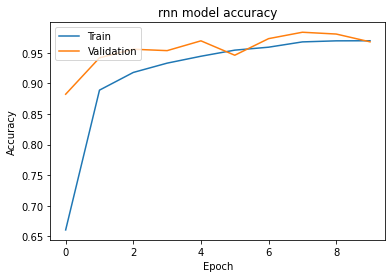

Training cnn model...
Epoch 1/10
383/383 [==============================] - 18s 46ms/step - loss: 0.3712 - accuracy: 0.6471 - val_loss: 0.2023 - val_accuracy: 0.8411
Epoch 2/10
383/383 [==============================] - 18s 46ms/step - loss: 0.1464 - accuracy: 0.8937 - val_loss: 0.1244 - val_accuracy: 0.9057
Epoch 3/10
383/383 [==============================] - 18s 46ms/step - loss: 0.1011 - accuracy: 0.9304 - val_loss: 0.0861 - val_accuracy: 0.9308
Epoch 4/10
383/383 [==============================] - 18s 46ms/step - loss: 0.0754 - accuracy: 0.9482 - val_loss: 0.0457 - val_accuracy: 0.9710
Epoch 5/10
383/383 [==============================] - 18s 46ms/step - loss: 0.0582 - accuracy: 0.9614 - val_loss: 0.0406 - val_accuracy: 0.9762
Epoch 6/10
383/383 [==============================] - 18s 46ms/step - loss: 0.0449 - accuracy: 0.9703 - val_loss: 0.0259 - val_accuracy: 0.9840
Epoch 7/10
383/383 [==============================] - 18s 46ms/step - loss: 0.0358 - accuracy: 0.9775 - val_loss: 

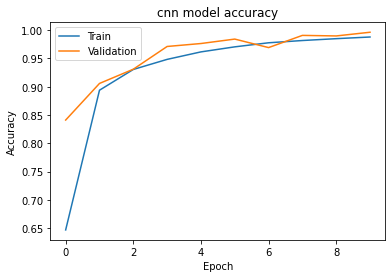

Training lstm model...
Epoch 1/10


2023-03-26 17:19:32.162359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 17:19:32.163983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 17:19:32.165305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

383/383 [==============================] - ETA: 0s - loss: 0.3248 - accuracy: 0.7022

2023-03-26 17:19:56.518129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 17:19:56.519589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 17:19:56.520773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

383/383 [==============================] - 26s 63ms/step - loss: 0.3248 - accuracy: 0.7022 - val_loss: 0.1346 - val_accuracy: 0.9083
Epoch 2/10
383/383 [==============================] - 24s 63ms/step - loss: 0.1446 - accuracy: 0.8960 - val_loss: 0.0913 - val_accuracy: 0.9360
Epoch 3/10
383/383 [==============================] - 25s 64ms/step - loss: 0.1151 - accuracy: 0.9154 - val_loss: 0.0877 - val_accuracy: 0.9406
Epoch 4/10
383/383 [==============================] - 24s 63ms/step - loss: 0.0932 - accuracy: 0.9363 - val_loss: 0.0849 - val_accuracy: 0.9373
Epoch 5/10
383/383 [==============================] - 24s 64ms/step - loss: 0.0803 - accuracy: 0.9449 - val_loss: 0.0447 - val_accuracy: 0.9700
Epoch 6/10
383/383 [==============================] - 25s 66ms/step - loss: 0.0707 - accuracy: 0.9528 - val_loss: 0.0496 - val_accuracy: 0.9687
Epoch 7/10
383/383 [==============================] - 25s 65ms/step - loss: 0.0630 - accuracy: 0.9580 - val_loss: 0.0503 - val_accuracy: 0.9726
Epo

2023-03-26 17:23:41.658377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 17:23:41.659456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 17:23:41.660408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

82/82 [==============================] - 1s 11ms/step
lstm model confusion matrix:
[[446  16  31   8]
 [ 19 717  76  11]
 [ 39  46 879  10]
 [  2   5  10 302]]
lstm model classification report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       501
           1       0.91      0.87      0.89       823
           2       0.88      0.90      0.89       974
           3       0.91      0.95      0.93       319

    accuracy                           0.90      2617
   macro avg       0.90      0.90      0.90      2617
weighted avg       0.90      0.90      0.90      2617

lstm model accuracy: 0.8957
lstm model precision: 0.8977
lstm model recall: 0.9026


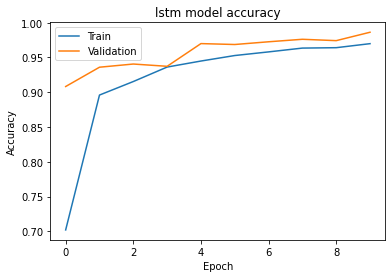

Training bilstm model...
Epoch 1/10


2023-03-26 17:23:43.031252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 17:23:43.032503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 17:23:43.033485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

383/383 [==============================] - ETA: 0s - loss: 0.3104 - accuracy: 0.7234

2023-03-26 17:24:13.271876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 17:24:13.273228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 17:24:13.274451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

383/383 [==============================] - 32s 78ms/step - loss: 0.3104 - accuracy: 0.7234 - val_loss: 0.1424 - val_accuracy: 0.9164
Epoch 2/10
383/383 [==============================] - 31s 80ms/step - loss: 0.1422 - accuracy: 0.8963 - val_loss: 0.0577 - val_accuracy: 0.9615
Epoch 3/10
383/383 [==============================] - 31s 81ms/step - loss: 0.1098 - accuracy: 0.9214 - val_loss: 0.0656 - val_accuracy: 0.9586
Epoch 4/10
383/383 [==============================] - 30s 79ms/step - loss: 0.0932 - accuracy: 0.9336 - val_loss: 0.0603 - val_accuracy: 0.9579
Epoch 5/10
383/383 [==============================] - 30s 77ms/step - loss: 0.0809 - accuracy: 0.9447 - val_loss: 0.0465 - val_accuracy: 0.9749
Epoch 6/10
383/383 [==============================] - 30s 78ms/step - loss: 0.0698 - accuracy: 0.9525 - val_loss: 0.0561 - val_accuracy: 0.9664
Epoch 7/10
383/383 [==============================] - 30s 77ms/step - loss: 0.0621 - accuracy: 0.9579 - val_loss: 0.0513 - val_accuracy: 0.9680
Epo

2023-03-26 17:28:45.427276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 17:28:45.428777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 17:28:45.429794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

82/82 [==============================] - 1s 12ms/step
bilstm model confusion matrix:
[[443  14  40   4]
 [ 19 738  62   4]
 [ 37  62 872   3]
 [  4   6  12 297]]
bilstm model classification report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       501
           1       0.90      0.90      0.90       823
           2       0.88      0.90      0.89       974
           3       0.96      0.93      0.95       319

    accuracy                           0.90      2617
   macro avg       0.91      0.90      0.90      2617
weighted avg       0.90      0.90      0.90      2617

bilstm model accuracy: 0.8980
bilstm model precision: 0.9073
bilstm model recall: 0.9018


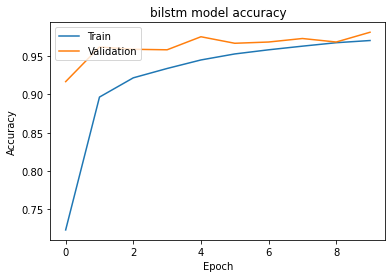

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from keras.layers import SimpleRNN, Dense



# Load the data
df = pd.read_csv('final_project_cleaned.csv')

# Preprocess the text data
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into text
    text = ' '.join(tokens)
    return text

df['text'] = df['text'].apply(preprocess_text)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Tokenize the text data and pad the sequences to a fixed length
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq_padded = pad_sequences(X_train_seq, maxlen=100)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq_padded = pad_sequences(X_test_seq, maxlen=100)

# Use RandomOversampling to oversample the minority classes in the training data
ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)

# Define the models
def create_rnn(num_words=20000, embedding_dim=100, rnn_units=64, dense_size=64, dropout_rate=0.3, max_seq_length=100):
    rnn_model = Sequential([
        Embedding(num_words, embedding_dim, input_length=max_seq_length),
        SimpleRNN(units=rnn_units, return_sequences=False),
        Dense(dense_size, activation='relu'),
        Dropout(dropout_rate),
        Dense(4, activation='softmax')
    ])
    return rnn_model

def create_cnn(num_words=20000, embedding_size=128, filter_size=32, kernel_size=3, pool_size=2, dense_size=64, dropout_rate=0.3):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    return model

def create_lstm(num_words=20000, lstm_size=64, embedding_size=128, dropout_rate=0.3, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(LSTM(lstm_size))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    return model



def create_bilstm(num_words=20000, lstm_size=64, embedding_size=128, dropout_rate=0.3, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Bidirectional(LSTM(lstm_size)))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    return model





y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values





# Compile the models
models = {
    'rnn': create_rnn(),
    'cnn': create_cnn(),
    'lstm': create_lstm(),
    'bilstm': create_bilstm()
}
for name, model in models.items():
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define a callback to save the model with the best validation accuracy
best_model = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')

# Train the models
epochs = 10
batch_size = 32


for name, model in models.items():
    print(f'Training {name} model...')
    history = model.fit(X_train_resampled, y_train_resampled_cat, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[best_model])
    y_pred = model.predict(X_test_seq_padded)
    y_pred = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_test, y_pred)
    print(f'{name} model confusion matrix:')
    print(cm)
    print(f'{name} model classification report:')
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    print(f'{name} model accuracy: {accuracy:.4f}')
    print(f'{name} model precision: {precision:.4f}')
    print(f'{name} model recall: {recall:.4f}')
    
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{name} model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
  


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'num_words': [10000, 20000],
    'embedding_dim': [50, 100, 200],
    'rnn_units': [32, 64, 128],
    'dense_size': [32, 64, 128],
    'dropout_rate': [0.2, 0.3, 0.4],
    'max_seq_length': [50, 100]
}

# Create the RNN model
model = KerasClassifier(build_fn=create_rnn, epochs=5, batch_size=32)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat)

# Print the best parameters and accuracy score
print("Best Parameters: ", grid_result.best_params_)
print("Best Accuracy Score: ", grid_result.best_score_)

2023-03-26 17:07:30.719201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 17:07:30.720526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 17:07:30.721526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Training rnn model...
Epoch 1/10


2023-03-26 17:07:30.992281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-03-26 17:07:31.025229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 17:07:31.026105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

132/132 [==============================] - 6s 41ms/step - loss: 0.4617 - accuracy: 0.5289 - val_loss: 0.9851 - val_accuracy: 0.0000e+00
Epoch 2/10
132/132 [==============================] - 5s 40ms/step - loss: 0.2481 - accuracy: 0.8077 - val_loss: 0.7202 - val_accuracy: 0.1418
Epoch 3/10
132/132 [==============================] - 5s 40ms/step - loss: 0.1602 - accuracy: 0.8805 - val_loss: 0.4003 - val_accuracy: 0.6689
Epoch 4/10
132/132 [==============================] - 5s 40ms/step - loss: 0.1095 - accuracy: 0.9203 - val_loss: 0.2814 - val_accuracy: 0.7945
Epoch 5/10
132/132 [==============================] - 5s 40ms/step - loss: 0.1015 - accuracy: 0.9288 - val_loss: 0.2587 - val_accuracy: 0.8021
Epoch 6/10
132/132 [==============================] - 5s 40ms/step - loss: 0.0673 - accuracy: 0.9586 - val_loss: 0.2307 - val_accuracy: 0.8363
Epoch 7/10
132/132 [==============================] - 5s 40ms/step - loss: 0.0544 - accuracy: 0.9624 - val_loss: 0.2992 - val_accuracy: 0.7888
Epoch 

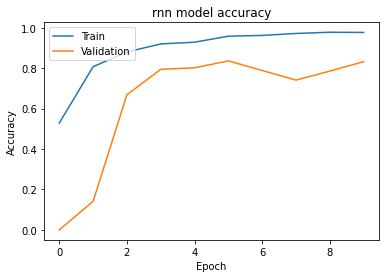

Training cnn model...
Epoch 1/10
132/132 [==============================] - 7s 47ms/step - loss: 0.5013 - accuracy: 0.4647 - val_loss: 0.9663 - val_accuracy: 0.0000e+00
Epoch 2/10
132/132 [==============================] - 6s 46ms/step - loss: 0.2723 - accuracy: 0.7853 - val_loss: 0.7961 - val_accuracy: 0.1437
Epoch 3/10
132/132 [==============================] - 6s 48ms/step - loss: 0.1629 - accuracy: 0.8846 - val_loss: 0.3968 - val_accuracy: 0.7317
Epoch 4/10
132/132 [==============================] - 6s 46ms/step - loss: 0.1048 - accuracy: 0.9312 - val_loss: 0.3272 - val_accuracy: 0.7935
Epoch 5/10
132/132 [==============================] - 6s 46ms/step - loss: 0.0743 - accuracy: 0.9498 - val_loss: 0.2602 - val_accuracy: 0.8278
Epoch 6/10
132/132 [==============================] - 6s 49ms/step - loss: 0.0567 - accuracy: 0.9645 - val_loss: 0.3067 - val_accuracy: 0.8164
Epoch 7/10
132/132 [==============================] - 6s 48ms/step - loss: 0.0439 - accuracy: 0.9724 - val_loss: 0.2

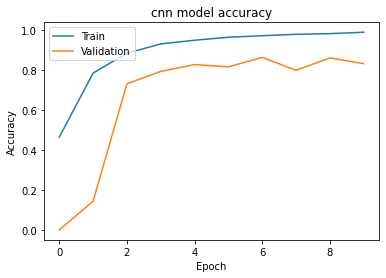

Training lstm model...
Epoch 1/10


2023-03-26 17:09:28.716264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 17:09:28.717622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 17:09:28.718847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

132/132 [==============================] - ETA: 0s - loss: 0.4795 - accuracy: 0.4965

2023-03-26 17:09:38.453983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 17:09:38.455208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 17:09:38.456157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

132/132 [==============================] - 10s 68ms/step - loss: 0.4795 - accuracy: 0.4965 - val_loss: 0.8888 - val_accuracy: 0.0000e+00
Epoch 2/10
132/132 [==============================] - 10s 75ms/step - loss: 0.2813 - accuracy: 0.7767 - val_loss: 0.8440 - val_accuracy: 0.0000e+00
Epoch 3/10
132/132 [==============================] - 9s 67ms/step - loss: 0.1935 - accuracy: 0.8522 - val_loss: 0.5986 - val_accuracy: 0.4615
Epoch 4/10
132/132 [==============================] - 9s 66ms/step - loss: 0.1373 - accuracy: 0.9038 - val_loss: 0.3748 - val_accuracy: 0.7098
Epoch 5/10
132/132 [==============================] - 9s 65ms/step - loss: 0.1075 - accuracy: 0.9260 - val_loss: 0.2244 - val_accuracy: 0.8573
Epoch 6/10
132/132 [==============================] - 9s 65ms/step - loss: 0.0912 - accuracy: 0.9367 - val_loss: 0.1616 - val_accuracy: 0.8953
Epoch 7/10
132/132 [==============================] - 9s 65ms/step - loss: 0.0762 - accuracy: 0.9469 - val_loss: 0.1759 - val_accuracy: 0.8792


2023-03-26 17:10:58.085379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 17:10:58.086472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 17:10:58.087358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

82/82 [==============================] - 1s 10ms/step
lstm model confusion matrix:
[[437  29  31   4]
 [ 24 738  59   2]
 [ 75 150 744   5]
 [ 11  29  13 266]]
lstm model classification report:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       501
           1       0.78      0.90      0.83       823
           2       0.88      0.76      0.82       974
           3       0.96      0.83      0.89       319

    accuracy                           0.83      2617
   macro avg       0.85      0.84      0.84      2617
weighted avg       0.84      0.83      0.83      2617

lstm model accuracy: 0.8349
lstm model precision: 0.8544
lstm model recall: 0.8417


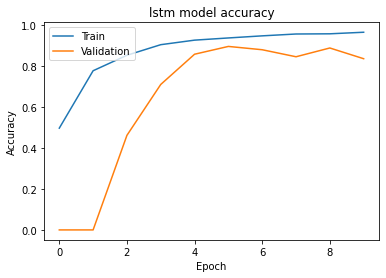

Training bilstm model...
Epoch 1/10


2023-03-26 17:10:59.292457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 17:10:59.293604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 17:10:59.294847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

132/132 [==============================] - ETA: 0s - loss: 0.4802 - accuracy: 0.4956

2023-03-26 17:11:11.327607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 17:11:11.328997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 17:11:11.329948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

132/132 [==============================] - 13s 82ms/step - loss: 0.4802 - accuracy: 0.4956 - val_loss: 0.8693 - val_accuracy: 0.0000e+00
Epoch 2/10
132/132 [==============================] - 10s 77ms/step - loss: 0.2680 - accuracy: 0.7917 - val_loss: 0.6756 - val_accuracy: 0.0799
Epoch 3/10
132/132 [==============================] - 10s 78ms/step - loss: 0.1704 - accuracy: 0.8741 - val_loss: 0.3558 - val_accuracy: 0.7536
Epoch 4/10
132/132 [==============================] - 10s 78ms/step - loss: 0.1225 - accuracy: 0.9131 - val_loss: 0.2124 - val_accuracy: 0.8763
Epoch 5/10
132/132 [==============================] - 10s 78ms/step - loss: 0.1012 - accuracy: 0.9295 - val_loss: 0.1991 - val_accuracy: 0.8820
Epoch 6/10
132/132 [==============================] - 10s 78ms/step - loss: 0.0876 - accuracy: 0.9391 - val_loss: 0.2736 - val_accuracy: 0.8392
Epoch 7/10
132/132 [==============================] - 10s 78ms/step - loss: 0.0932 - accuracy: 0.9372 - val_loss: 0.2356 - val_accuracy: 0.8554

2023-03-26 17:12:44.788097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 17:12:44.789210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 17:12:44.790208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

82/82 [==============================] - 1s 12ms/step
bilstm model confusion matrix:
[[452  15  26   8]
 [ 28 694  86  15]
 [ 83  75 803  13]
 [  9  12  13 285]]
bilstm model classification report:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       501
           1       0.87      0.84      0.86       823
           2       0.87      0.82      0.84       974
           3       0.89      0.89      0.89       319

    accuracy                           0.85      2617
   macro avg       0.85      0.87      0.86      2617
weighted avg       0.86      0.85      0.85      2617

bilstm model accuracy: 0.8536
bilstm model precision: 0.8538
bilstm model recall: 0.8658


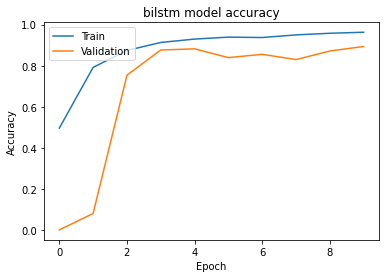

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from keras.layers import SimpleRNN, Dense



# Load the data
df = pd.read_csv('final_project_cleaned.csv')

# Preprocess the text data
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into text
    text = ' '.join(tokens)
    return text

df['text'] = df['text'].apply(preprocess_text)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Tokenize the text data and pad the sequences to a fixed length
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq_padded = pad_sequences(X_train_seq, maxlen=100)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq_padded = pad_sequences(X_test_seq, maxlen=100)

# Use RandomOversampling to oversample the minority classes in the training data
ros = RandomUnderSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)

# Define the models
def create_rnn(num_words=20000, embedding_dim=100, rnn_units=64, dense_size=64, dropout_rate=0.3, max_seq_length=100):
    rnn_model = Sequential([
        Embedding(num_words, embedding_dim, input_length=max_seq_length),
        SimpleRNN(units=rnn_units, return_sequences=False),
        Dense(dense_size, activation='relu'),
        Dropout(dropout_rate),
        Dense(4, activation='softmax')
    ])
    return rnn_model

def create_cnn(num_words=20000, embedding_size=128, filter_size=32, kernel_size=3, pool_size=2, dense_size=64, dropout_rate=0.3):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    return model

def create_lstm(num_words=20000, lstm_size=64, embedding_size=128, dropout_rate=0.3, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(LSTM(lstm_size))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    return model



def create_bilstm(num_words=20000, lstm_size=64, embedding_size=128, dropout_rate=0.3, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Bidirectional(LSTM(lstm_size)))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    return model





y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values





# Compile the models
models = {
    'rnn': create_rnn(),
    'cnn': create_cnn(),
    'lstm': create_lstm(),
    'bilstm': create_bilstm()
}
for name, model in models.items():
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define a callback to save the model with the best validation accuracy
best_model = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')

# Train the models
epochs = 10
batch_size = 32


for name, model in models.items():
    print(f'Training {name} model...')
    history = model.fit(X_train_resampled, y_train_resampled_cat, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[best_model])
    y_pred = model.predict(X_test_seq_padded)
    y_pred = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_test, y_pred)
    print(f'{name} model confusion matrix:')
    print(cm)
    print(f'{name} model classification report:')
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    print(f'{name} model accuracy: {accuracy:.4f}')
    print(f'{name} model precision: {precision:.4f}')
    print(f'{name} model recall: {recall:.4f}')
    
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{name} model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
  
